In [11]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, date

# Group Assignment
### Team Number: 11
### Team Member Names: Jeffrey, Ray, Baldeep
### Team Strategy Chosen: RISKY (RISKY OR SAFE)

# An Introduction


As a culmination of CFM101, we were challenged to create a portfolio. A portfolio that could be either the riskiest or safest. In the real world, just about every experienced investor would be interested in a safe portfolio, where positive returns would not only be probable, but expected. We, on the other hand, had a different vision in mind. We created the riskiest possible portfolio, given our $750 000 starting investment, with the hopes of either losing as much money as possible, or gaining as much money as possible, and thus see the most possible movement, after five days, over. With this, we are creating a robo-advisor that would most certainly be just about the most counter-intuitive portfolio-building financial advisor, but it will be a robo-advisor, nevertheless. Join us on our process to create our fantastic robo-advisor!


# Initialization of Variables

In [12]:
# List of Tickers to Choose From
ticker_list = pd.read_csv("Tickers.csv")

# Initial Capital (CAD)
capital = 750000

# Trading Fee
trading_fee = 4.95

# Restrictions
avg_month_vol = 150000
min_month_days = 18
currency = ['USD', 'CAD']

# Number of stocks in our Portfolio
num_stocks = 10

# Minimum weight for each stock in the portfolio (in decimals)
min_weight = 1 / (2 * num_stocks)

# Maximum weight for each stock in the portfolio (in decimals)
max_weight = 0.2

# Day that we will purchase stocks for our portfolio
purchase_date = '2023-11-24'

In [13]:
# Portfolios
Portfolio_Final = pd.DataFrame()
Stocks_Final = pd.DataFrame()

# Filtering the tickers

### Before creating our portfolio of stocks, we must first create a filter function to filter out unwanted tickers for this assignment. 

## We have to consider:
### 1) Are the stocks delisted?
### 2) Are the stocks denominated in USD or CAD?
### 3) Do the months have at least 18 trading days?
### 4) Do the stocks have an average monthly volume of at least 150 000 shares? 


1) To do this, we loop through every ticker in the ticker_lst and check if calling fast_info produces an error. If it produces an error, we know the stock is delisted, so we don't add that ticker to the new ticker list. 

2) We get the fast_info of the stock and check if the currency is either USD or CAD. If it is, we add it to the new ticker list. 

3) We use a stock index from the TSX and another from the NYSE and concat the historical data together such that only the days that appear in both are kept. Then, we loop through every month and count the total number of days. If the number of days is less than 18, then we add it to a list and remove the month from the dataframes later. 

4) Using the historical data, we calculate the average monthly volume for each stock by looping through all the valid stocks and then using the mean function. If the average monthly volume is less than 150 000, then we remove the stock from the stock list. 

In [14]:
#define start date and end date variables
start_date = '2023-01-01'
end_date = '2023-10-31'

#define holder variables
stock_hist_data = []
invalid_months = []

#produce a list of all the tickers
ticker_lst = ticker_list[ticker_list.columns[0]]

#filter stocks variable 
def filter_stocks(ticker_lst):
    new_ticker_lst=[]
    
    #loop through every ticker in the ticker_lst and check if it is listed and has a currency of USD or CAD
    for cur_ticker in ticker_lst:
        info = yf.Ticker(cur_ticker).fast_info
        try:
            #check if the currency is USD or CAD
            if(info.currency == 'USD' or info.currency == 'CAD'):
                new_ticker_lst.append(cur_ticker)
        except:
            #output a statement if the stock is delisted
            print(f"{cur_ticker} is not a valid ticker")
    
    #get the historical data of each ticker and add it to a list
    for cur_ticker in new_ticker_lst:
        temp_ticker = yf.Ticker(cur_ticker)
        hist = temp_ticker.history(start=start_date, end=end_date, interval = '1mo')
        stock_hist_data.append(hist)
    
    cad_index = '^GSPTSE' #S&P/TSX Composite Index (CAD)
    usa_index = '^GSPC' #S&P500 Composite Index (USD)
    
    #loop through every month and check if the month has less than 18 trading days
    for cur_month in range(1, 11):
        #get the historical dataframes of the two indexes
        cad_days = yf.Ticker(cad_index).history(start = str(date(2023, cur_month, 1)), end = str(date(2023, cur_month+1, 1)))
        usd_days = yf.Ticker(usa_index).history(start = str(date(2023, cur_month, 1)), end = str(date(2023, cur_month+1, 1)))
        #merge the two dataframes and only keep the duplicates
        total_days = cad_days.reindex(usd_days.index)
        num_days = len(total_days)
        if num_days < min_month_days:
            invalid_months.append(cur_month)
            
    #remove the months that have less than 18 trading days
    for i in range(len(stock_hist_data)):
        cur_hist = stock_hist_data[i]
        for month in invalid_months:
            if month < 10:
                cur_hist.filter(like!=f'2023-0{month}', axis=0)
            else:
                cur_hist.filter(like != f'2023-{month}', axis=0)
    #Calculate the average monthly volume for each stock and remove the stock if it is less than 150 000
    for i in range(len(new_ticker_lst)): 
        cur_ticker = new_ticker_lst[i]
        cur_hist = stock_hist_data[i]
        avgMonthlyVolume = cur_hist['Volume'].mean()
        #check if the average monthly volume is less than 150 000 and remove the stock if it is
        if avgMonthlyVolume < avg_month_vol:
            new_ticker_lst.remove(cur_ticker)
            stock_hist_data.remove(cur_hist)
    return new_ticker_lst

#call the function
filtered_ticker_lst = filter_stocks(ticker_lst)
filtered_ticker_lst

AGN is not a valid ticker
CELG is not a valid ticker
MON is not a valid ticker
RTN is not a valid ticker


['ABBV',
 'ABT',
 'ACN',
 'AIG',
 'AMZN',
 'AXP',
 'BA',
 'BAC',
 'BIIB',
 'BK',
 'BLK',
 'BMY',
 'C',
 'CAT',
 'CL',
 'KO',
 'LLY',
 'LMT',
 'MO',
 'MRK',
 'PEP',
 'PFE',
 'PG',
 'PM',
 'PYPL',
 'QCOM',
 'RY.TO',
 'SHOP.TO',
 'T.TO',
 'TD.TO',
 'TXN',
 'UNH',
 'UNP',
 'UPS',
 'USB']

# Computing Historical Data


The first step in selecting our stocks for the portfolio is to compute the historical data for each stock.

We decided to pull our data starting from January 2022 until the present. We chose to start from 2022 because we know COVID-19 ended in 2021 and it heavily affected the stock market and its prices. Thus, by avoiding that period of time, our data will be much more reliable and accurate for predicting the future prices.

Also, we decided to take the weekly prices of the stocks as taking the daily prices would create too much variation and volatility and taking the monthly prices wouldn't give us enough data. Thus, taking the weekly prices appeared to be a good medium.

In addition, since our stocks consist of both CAD and USD stocks, we converted the USD stocks into CAD by dividing the price of the USD stock by the exchange rate (USD to CAD) of the same day.

After converting the USD stocks to CAD, we took the weekly percent changes of each stock and stored them in a dataframe to be used for other calculations.

In [15]:
#define start date and end date
compute_start_date = '2022-01-01'
compute_end_date = '2023-11-23'

#get the exchange rate for the compute start date
cad_usd = yf.Ticker('CADUSD=X')
cad_usd_hist = cad_usd.history(start=compute_start_date, end=compute_end_date, interval = '1wk')
cad_usd_hist.index = pd.DatetimeIndex(cad_usd_hist.index).tz_localize(None, ambiguous='infer').tz_localize('UTC')

weekly_pct_change = pd.DataFrame()

#loop through each ticker and add the percent change of the weekly closing price to the dataframe
for ticker in filtered_ticker_lst:
    hist = yf.Ticker(ticker).history(start=compute_start_date, end=compute_end_date, interval = '1wk')
    hist.index = pd.DatetimeIndex(hist.index).tz_localize(None, ambiguous='infer').tz_localize('UTC')
    temp_currency = yf.Ticker(ticker).fast_info['currency']
    #convert the USD close prices to CAD
    if temp_currency == 'USD':
        hist['Close'] = hist['Close']/cad_usd_hist['Close']
    weekly_pct_change[ticker] = hist.Close.pct_change()

#drop the NaN values
weekly_pct_change = weekly_pct_change.dropna()

#output the weekly percent changes of each stock
weekly_pct_change

    


,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,BK,...,QCOM,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-08 00:00:00+00:00,-0.010259,-0.071105,-0.063556,0.001456,-0.019985,-0.048783,0.030220,-0.042843,0.010831,0.002549,...,0.027624,0.039083,-0.044331,0.005394,0.032304,0.023979,0.004147,-0.050288,-0.069803,0.018771
2022-01-15 00:00:00+00:00,-0.019139,-0.015308,-0.048284,-0.074695,-0.120765,-0.057929,-0.091358,-0.062971,-0.079031,-0.101482,...,-0.126445,-0.017924,-0.196567,-0.014085,-0.021081,-0.061362,-0.016635,-0.000356,-0.022810,-0.129376
2022-01-22 00:00:00+00:00,0.065522,0.015742,0.041566,0.013228,0.029174,0.137306,-0.054171,0.041195,0.041317,0.042813,...,0.031254,-0.010163,0.003224,0.016667,-0.000897,0.029210,0.030443,0.017976,0.000951,0.074777
2022-01-29 00:00:00+00:00,0.014417,0.029327,0.008219,0.065106,0.089113,0.044110,0.077617,0.046990,-0.021527,0.057530,...,0.070222,0.034432,0.003824,0.031114,0.053987,-0.031838,0.031246,-0.019591,0.127893,0.022473
2022-02-05 00:00:00+00:00,0.013930,-0.028452,-0.048722,0.000103,-0.023466,0.036424,0.032675,-0.003268,-0.027240,0.012668,...,-0.078761,-0.004221,-0.025656,0.024335,0.020735,-0.036905,-0.006255,-0.010612,-0.046261,-0.015125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-21 00:00:00+00:00,-0.043084,-0.033704,-0.016407,0.007365,0.027876,0.005346,0.005238,-0.036445,-0.082511,0.006471,...,-0.012924,-0.022881,-0.082026,-0.004973,-0.032397,-0.024762,0.002667,-0.038650,-0.106342,-0.002247
2023-10-28 00:00:00+00:00,0.012986,0.027196,0.075609,0.065527,0.079754,0.075784,0.080216,0.123646,0.058715,0.092650,...,0.117230,0.083128,0.306294,0.101772,0.063288,0.044588,0.006986,0.046506,0.054417,0.152672
2023-11-04 00:00:00+00:00,-0.015734,-0.015232,0.024228,0.005625,0.040307,0.015016,0.012603,-0.021787,-0.095106,0.013465,...,0.043776,0.006290,0.007257,-0.018969,0.012102,-0.006939,0.023869,0.001334,-0.029030,-0.032142


## Standard Deviation


In creating a risky portfolio, we require a group of stock tickers that are unpredictable and have a high varience when compared to their mean values. These tickers would have large periods of unprecedented growhth and loss, and would be an investors greatest dream come true, or worst nightmare, depending on the performance ot the stock. For the purposes of our portfolio, we are calculating the standard deviation of all of the filtered tickers, and moving forward with the tickers in order of highest to lowest standard deviations. 

\begin{align*}
\sigma_X=\sqrt{\frac{\sum(x_i-\overline{X})^2}{N}}
\end{align*}

In [16]:
# Function to return the tickers of the firms in order of highest to lowest standard deviation
def highest_std(dataframe):
    
    # Setting variables
    temp_std = 0 
    list_of_stds = []
    list_of_tickers = []
    
    # Looping through every column in the datafarme
    for x in dataframe.columns:
        temp_std = abs(dataframe[x].std())
        list_of_stds.append(temp_std)
    
    # Return a dataframe with the list of standard deviations
    global stds_dataframe
    stds_dataframe = pd.DataFrame(list_of_stds, index=dataframe.columns, columns=['std'])
    stds_dataframe.sort_values("std", inplace=True, ascending=False)
    
    for x in range (len(stds_dataframe.index)):
        temp_ticker = (stds_dataframe.index[x])
        list_of_tickers.append(temp_ticker)
        
    
    return list_of_tickers

print(highest_std(weekly_pct_change))

['SHOP.TO', 'PYPL', 'BA', 'AMZN', 'BIIB', 'USB', 'QCOM', 'CAT', 'BLK', 'AXP', 'BAC', 'LLY', 'C', 'ACN', 'BK', 'AIG', 'UPS', 'LMT', 'TXN', 'ABT', 'PFE', 'ABBV', 'UNP', 'PM', 'UNH', 'MRK', 'MO', 'TD.TO', 'BMY', 'PG', 'T.TO', 'CL', 'PEP', 'KO', 'RY.TO']


## Correlation and Covarience

Since we have 10 tickers, then the minimum weight for each is 5% and the max is 20%. We want highest variance and
volatility of the stocks (risky strategy). So, loop through the tickers found above with the highest standard
deviation function, and for each (call this stock the base stock), find the 9 stocks that have the highest correlation to to the base stock in decreasing order. (meaning that the first stock will have the highest correlation
to the base stock, the second stock will have the second highest correlation to the base stock, and so on.) Then,
put 20% in the base stock, the first stock, the second stock, 10% in the third stock, and 5% in the rest in order
to maximize the expected combined correlation (weight * correlation). To calculate correlation of two securities, first we need to know how to calculate the covarience of the two securities, which can be found using the following formula, where 
$x_i, y_i$ represents the individual returns of a securities X and Y, $\overline{X}, \overline{Y}$ represent the mean returns of securities X and Y, and $N$ is the total number of observations/time periods.

\begin{align*}
COV(X,Y)=\frac{\sum(x_i-\overline{X})\times(y_i-\overline{Y})}{N}
\end{align*}

Covarience provides us an understanding on how two variables change in relation to each other statistically. Correlation is essentially the same as covarience, but is more standardized by dividing the covarience by the standard deviation of the datasets. Correlation ranges from -1 to 1, with a value of 1 suggesting that both variables are moving in tandem, and a value of -1 suggesting that the variables move directly opposite of each other. To calculate correlation, take the covarience calculated above and divide by the product of the standard deviation of security X and security Y

\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}


---------------------------------------------------------------------------
The portfolio with the highest average percent returns is portfolio 25
---------------------------------------------------------------------------


,UNH,MRK,LLY,PEP,LMT,ABBV,PFE,KO,BMY,PG
Date,,,,,,,,,,
2022-01-08 00:00:00+00:00,0.004147,-0.004256,-0.075703,-0.008665,0.016578,-0.010259,-0.031048,-0.000207,0.024267,-0.035160
2022-01-15 00:00:00+00:00,-0.016635,-0.017792,-0.004939,-0.008679,-0.004408,-0.019139,-0.039884,-0.015902,-0.021994,0.016973
2022-01-22 00:00:00+00:00,0.030443,0.031360,0.028189,0.010560,0.079925,0.065522,0.049376,0.026210,0.041616,0.011773
2022-01-29 00:00:00+00:00,0.031246,-0.034045,-0.016758,-0.006309,-0.014938,0.014417,-0.022245,-0.003310,-0.004046,0.001111
2022-02-05 00:00:00+00:00,-0.006255,-0.020323,-0.022847,-0.018544,0.021914,0.013930,-0.037844,-0.006817,0.033424,-0.028357


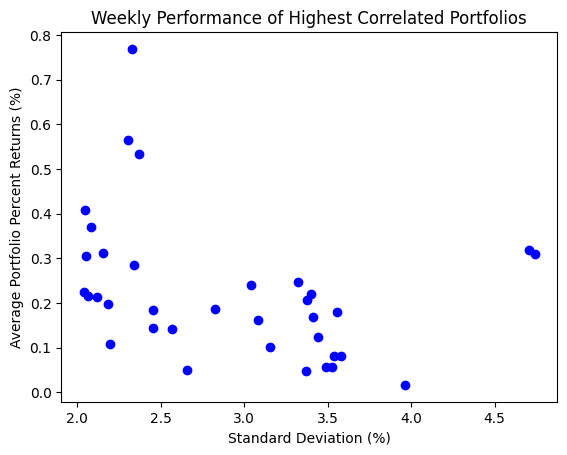

In [17]:
# To find which portfolio gives the best percent returns
pfl_pct_returns = []

# Made into a function for future use
def correlation_pfl(tkr_lst, return_lst, graph_sym="b"):
    
    '''
    From all the tickers in tkr_lst, finds the next 9 highest correlated stocks and creates a weighted portfolio. Then 
    using historical data from Jan 1, 2022 to Nov 21, 2023, find the portfolio average percent returns and appends the 
    value to the return_lst
    ''' 
    for i in tkr_lst:
        temp_df = pd.DataFrame()
        correlation = weekly_pct_change.corr()[i]
        correlation = correlation.sort_values(ascending=False)
        
        # List of largest correlation values to the base stock
        stock_lst = [k for k in (correlation.index[:10])]
        
        # To get the portfolio of each and calculate average percent returns
        for x in stock_lst:
            temp_df[x] = weekly_pct_change[x]
        
        # Finding the weighted returns of each stock in the portfolio
        count = 0
        for x in temp_df.columns:
            if count <= 2:
                temp_df[x] = temp_df[x] * 0.2
                count += 1
            elif count == 3:
                temp_df[x] = temp_df[x] * 0.1
                count += 1
            else:
                temp_df[x] = temp_df[x] * 0.05
                count += 1
        
        # To get the average portfolio percent returns in order to calculate standard eviation for graphing purposes
        temp_df["Portfolio Average Returns"] = temp_df.sum(1)
        
        # Finding the weighted average portfolio percent returns. Take absolute value of the average portfolio percent
        # returns since all we care about is maximum volatility and risk
        # (Increase or Decrease in Portfolio value does not matter)
        avg_pct_returns = temp_df.values.sum() / len(temp_df.index)
        return_lst.append(abs(avg_pct_returns))
        
        # To produce the graph relative to standard deviation of the portfolio
        if graph_sym == "c":
            avg_std = temp_df["Portfolio Average Returns"].std()
            plt.scatter(avg_std * 100, abs(avg_pct_returns) * 100, color='b')
            plt.title("Weekly Performance of Highest Correlated Portfolios")
            plt.xlabel("Standard Deviation (%)")
            plt.ylabel("Average Portfolio Percent Returns (%)")


# Running the Function
correlation_pfl(highest_std(weekly_pct_change), pfl_pct_returns, "c")
    
# Now find the index of the highest average percent returns and make a portfolio
max_index = pfl_pct_returns.index(max(pfl_pct_returns))
print("-"*75)
print(f"The portfolio with the highest average percent returns is portfolio {max_index+1}")
print("-"*75)

# Make the portfolio with the corresponding base stock
pfl = pd.DataFrame()
base_stock = highest_std(weekly_pct_change)[max_index]
correlation = weekly_pct_change.corr()[base_stock]
correlation = correlation.sort_values(ascending=False)
stock_lst = [k for k in (correlation.index[:10])]

for y in stock_lst:
    pfl[y] = weekly_pct_change[y]
    
display(pfl.head())

Having generated sample portfolios dependent on a combination of the stocks with the highest standard deviation, and tickers with the highest correlation, we noticed that the generated portfolios with the highest percentage returns had relatively lower standard deviations. This likely reflects highly correlated stocks, as since highly correlated stocks move similarly, the overall portfolio standard deviation would be low, while still producing high average portfolio percent returns as seen in the graph. Taking the stocks that had the highest standard deviations, we then applied our correlation function to see which stocks trended relatively similarly. If we had simply implemented a portfolio that had the stocks strictly with the highest standard deviations, it would be probable that certain stocks would trend in opposite directions, the portfolio would be diversified and as such, it would be safe, and not generate the drastic returns we desired. As such, due to correlation, it appears reasonable that our most successful portfolios, in terms of average weekly returns, have lower standard deviations, and highly correlated stocks.


## Beta


In the finance world, Beta is a measure of the volatility of a security compared ot the market at large. In creating a portfolio consisting of the set of the riskiest possible stocks and weightings, Beta appears to be almost the perfect statistical measure to determine which ticker is the riskiest. The function below returns a list of tickers in order of Beta, from highest to lowest. This information will be combined with Correlation and Covariance to determine which combination of risky stocks and weighting will create the riskiest, yet most profitable (or the exact opposite) portfolio.


\begin{align*}
\beta=\frac{COV(x_i,r_M)}{\sigma^2(r_M)}
\end{align*}

In [18]:
def highest_beta(dataframe):
    
    # Initializing information for the S&P 500 for US based stocks
    usa_index = '^GSPC' #S&P500 Composite Index (USD)
    
    # Initializing start and end date information
    compute_start_date = '2022-01-01'
    compute_end_date = '2023-11-21'
    
    sandp_ticker = yf.Ticker(usa_index)
    sandp_hist = sandp_ticker.history(start=compute_start_date, end=compute_end_date, interval = '1wk')
    sandp = pd.DataFrame(sandp_hist['Close'])
    
    # Creating a percentage change dataframe for the S&P 500
    daily_returns = sandp.pct_change()
    daily_returns.drop(index=daily_returns.index[0], inplace=True)
    daily_returns = daily_returns.set_index(dataframe.index)  # Assign back to daily_returns

    
    # Calculating Market Variance for beta calculation for US stocks
    MarketVarUSD = np.var(daily_returns['Close'])

    # Setting variables
    temp_beta = 0 
    covariance_market_stock = 0
    list_of_beta = []
    list_of_beta_tickers = []
    
    
    # Looping through every column in the dataframe to create to lists of tickers depending on
    for x in dataframe.columns:
        covariance_market_stock = dataframe[x].cov(daily_returns['Close'])
        temp_beta = covariance_market_stock / MarketVarUSD
        list_of_beta.append(temp_beta)        
          
            
    # Return a dataframe with the list of standard deviations
    global betas_dataframe
    betas_dataframe = pd.DataFrame(list_of_beta, index=dataframe.columns, columns=['beta'])
    betas_dataframe.sort_values("beta", inplace=True, ascending=False)
    
    for x in range (len (betas_dataframe)):
        temp_ticker2 = (betas_dataframe.index[x])
        list_of_beta_tickers.append(temp_ticker2)
        
    
    return list_of_beta_tickers

# Creating a portfolio for each stock based on the next 9 most correlated stock
beta_corr_returns = []
correlation_pfl(highest_beta(weekly_pct_change), beta_corr_returns)

# Now find the index of the highest returns and make a portfolio
max_index = beta_corr_returns.index(max(beta_corr_returns))
print("-"*75)
print(f"The portfolio with the highest average returns is portfolio {max_index+1}")
print("-"*75)

# Make the portfolio with the corresponding base stock
pfl_beta = pd.DataFrame()
base_stock = highest_std(weekly_pct_change)[max_index]
correlation = weekly_pct_change.corr()[base_stock]
correlation = correlation.sort_values(ascending=False)
stock_lst = [k for k in (correlation.index[:10])]

for y in stock_lst:
    pfl_beta[y] = weekly_pct_change[y]
    
display(pfl_beta.head())

---------------------------------------------------------------------------
The portfolio with the highest average returns is portfolio 33
---------------------------------------------------------------------------


,PEP,KO,PG,CL,MRK,PM,ABBV,UNH,LLY,MO
Date,,,,,,,,,,
2022-01-08 00:00:00+00:00,-0.008665,-0.000207,-0.035160,-0.028990,-0.004256,0.024550,-0.010259,0.004147,-0.075703,0.003061
2022-01-15 00:00:00+00:00,-0.008679,-0.015902,0.016973,0.002035,-0.017792,-0.005046,-0.019139,-0.016635,-0.004939,-0.010238
2022-01-22 00:00:00+00:00,0.010560,0.026210,0.011773,0.017574,0.031360,0.025576,0.065522,0.030443,0.028189,0.022874
2022-01-29 00:00:00+00:00,-0.006309,-0.003310,0.001111,-0.028389,-0.034045,-0.004600,0.014417,0.031246,-0.016758,-0.010987
2022-02-05 00:00:00+00:00,-0.018544,-0.006817,-0.028357,-0.015464,-0.020323,0.046583,0.013930,-0.006255,-0.022847,0.007821


# Finding the Best Portfolio Based on Average Weekly Percent Returns

In [19]:
if max(pfl_pct_returns) >= max(beta_corr_returns):
    final_pfl = pfl
else:
    final_pfl = pfl_beta
    
display(final_pfl.head())

,UNH,MRK,LLY,PEP,LMT,ABBV,PFE,KO,BMY,PG
Date,,,,,,,,,,
2022-01-08 00:00:00+00:00,0.004147,-0.004256,-0.075703,-0.008665,0.016578,-0.010259,-0.031048,-0.000207,0.024267,-0.035160
2022-01-15 00:00:00+00:00,-0.016635,-0.017792,-0.004939,-0.008679,-0.004408,-0.019139,-0.039884,-0.015902,-0.021994,0.016973
2022-01-22 00:00:00+00:00,0.030443,0.031360,0.028189,0.010560,0.079925,0.065522,0.049376,0.026210,0.041616,0.011773
2022-01-29 00:00:00+00:00,0.031246,-0.034045,-0.016758,-0.006309,-0.014938,0.014417,-0.022245,-0.003310,-0.004046,0.001111
2022-02-05 00:00:00+00:00,-0.006255,-0.020323,-0.022847,-0.018544,0.021914,0.013930,-0.037844,-0.006817,0.033424,-0.028357


# Create the portfolio

## To create the portfolio, we 
1) Subtract the trading fees from the total capital (we automatically assume 10 stocks because all of our portfolios were created with 10 stocks) 
2) Get the current cad_usd exchange rate 
3) Loop through each stock and calculate the current buy price and number of stocks based on the weighting

In [20]:
#Define lists

final_stocks = list(final_pfl.columns)

final_buy_prices = []
final_num_stocks = []
final_currency = []
final_weightings = [0.2, 0.2, 0.2, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

#subtract the trading fees 
capital -= num_stocks*trading_fee

#Add the lists to the final dataframe
Stocks_Final['Ticker'] = final_stocks

#get the current cad_usd exchange rate
final_cadusd = yf.Ticker('CADUSD=X')
final_cadusd_hist = final_cadusd.history(start=purchase_date)
final_exchange_rate = final_cadusd_hist.loc[purchase_date, 'Close']

#loop through each stock in the final portfolio and get the buy price and number of stocks 
for i in range(0, len(final_stocks)):
    ticker = final_stocks[i]
    final_hist = yf.Ticker(ticker).history(start=purchase_date)
    buy_price = final_hist.loc[purchase_date, 'Close']
    if yf.Ticker(ticker).fast_info['currency'] == 'USD':
        buy_price = buy_price/final_exchange_rate
        final_currency.append('USD')
    else:
        final_currency.append('CAD')
        
    final_buy_prices.append(buy_price)
    final_num_stocks.append((capital*final_weightings[i])/buy_price)

#add prices and number of stocks to the final dataframe
Stocks_Final['Price'] = final_buy_prices
Stocks_Final['Currency'] = final_currency
Stocks_Final['Shares'] = final_num_stocks
Stocks_Final['Value'] = Stocks_Final['Price']*Stocks_Final['Shares']
Stocks_Final['Weight'] = final_weightings

Stocks_Final.index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

final_total_value = Stocks_Final['Value'].sum()+num_stocks*trading_fee
print(f"The total value of the portfolio is: {round(final_total_value, 4)}")
print(f"The total weighting of the portfolio is: {round(Stocks_Final['Weight'].sum(), 4)}")

Stocks_Final

The total value of the portfolio is: 750000.0
The total weighting of the portfolio is: 1.0


,Ticker,Price,Currency,Shares,Value,Weight
1,UNH,746.706089,USD,200.868993,149990.100,0.20
2,MRK,139.510970,USD,1075.113306,149990.100,0.20
3,LLY,823.206423,USD,182.202296,149990.100,0.20
4,PEP,230.196890,USD,325.786547,74995.050,0.10
5,LMT,614.645965,USD,61.006705,37497.525,0.05
6,ABBV,189.908564,USD,197.450416,37497.525,0.05
7,PFE,41.769750,USD,897.719635,37497.525,0.05
8,KO,79.577969,USD,471.204853,37497.525,0.05
9,BMY,68.146318,USD,550.250197,37497.525,0.05
10,PG,207.314918,USD,180.872295,37497.525,0.05


In [21]:
# Write to CSV
Portfolio_Final = Stocks_Final[["Ticker", "Shares"]]
Portfolio_Final.to_csv("Stocks_Group_11.csv")

# Our final thoughts

In programming our robo-advisor which created a portfolio with the most drastic possible changes in total portfolio value, we utilized the best of our knowledge gained from our CFM classes, external research, trial and error and sheer toil. We used several statistical measures to optimize our portfolio in the manner we wanted, including the Standard Deviation, Beta, Covariance, Correlation and other factors. Ultimately we were able to create a robo-advisor that generated the riskiest weighted portfolio that covered all of our restrictions. This project was not easy, with it challenging our knowledge of key finance concepts, our expertise on the math and statistics behind securities and our programming abilities, but ultimately we were able to create a product that we were satisfied with, a product that should produce the portfolio that wins on December 4th! We thank Professor Thompson, the TAs and everyone that went into creating and planning this difficult, yet fulfilling course, and hope you understand and appreciate the process that went into creating our robo-advisor.


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Ray, Baldeep, Jeffrey